In [1]:
import os
import time

from selenium import webdriver

#edge=webdriver.Edge(executable_path=os.getcwd()+'\drivers\MicrosoftWebDriver.exe')

if (time.time() - os.stat("games_list.txt").st_mtime)/60 >= 24*60:
    try:
        browser=webdriver.Edge()
    except:
        browser.quit()
    finally:
        browser.get('https://api.overtrack.gg/games')
        text=browser.find_element_by_tag_name('body')
        file=open("games_list.txt","w")
        file.write(text.text)
        file.close() 
        browser.quit()

In [2]:
import json
from pandas.io.json import json_normalize 

with open('games_list.txt', 'r') as j:
    t=json.load(j)['games']
    
d=json_normalize(t)
df=d.drop(['custom_game','duration','rank','viewable','key','player_battletag','user_id','time','url'],axis=1)
qp=df.query('game_type == "quickplay" and map != "Unknown" and player_name == "ARODGERS" and result != "UNKNOWN"').drop(['game_type','player_name'],axis=1)
comp=df.query('game_type == "competitive" and map != "UNKNOWN" and player_name == "ARODGERS" and result != "UNKNOWN"').drop(['game_type','player_name'],axis=1)

df=qp

In [5]:
df=df[['map','result','start_sr','end_sr','heroes_played']]

import pandas as pd
map_wins=pd.DataFrame(index=df.map.unique(),columns=['games_won'])
map_wins['games_won']=[0]*len(map_wins)
map_wins['win_rate']=[0]*len(map_wins)
wins=df.query('result == "WIN"')
for m in wins.map:
    map_wins['games_won'].loc[m]+=1
map_wins=map_wins.reindex(df.map.value_counts().axes[0])
map_win_rates=pd.DataFrame(df.map.value_counts())
map_win_rates=map_win_rates.rename(columns={"map":"games_played"})
map_win_rates['games_won']=map_wins['games_won']
map_win_rates=map_win_rates[['games_won','games_played']]
map_win_rates['win_rate']=[0]*len(map_win_rates)
for m in map_wins.index:
    map_win_rates.win_rate.loc[m]=map_win_rates.games_won.loc[m]/map_win_rates.games_played.loc[m]
    
dps=['ashe','bastion','doomfist','genji','hanzo','junkrat','mccree','mei','pharah','reaper','soldier',
    'sombra','symmetra','torbjorn','tracer','widowmaker']
support=['ana','baptiste','brigitte','lucio','mercy','moira','zenyatta']
tank=['reinhardt','winston','hammond','zarya','orisa','sigma','dva','roadhog']
role_names=['tank','support','dps']
roles=[tank,support,dps]

points=pd.DataFrame(columns=['hero','role','map','win_points','hero_time','result'])
for i in range(0,len(df.heroes_played)):
    r=df.result.iloc[i]
    m=df.map.iloc[i]
    for j in df.heroes_played.iloc[i]:
        if(r=='WIN'):
            p=1
        if(r=='DRAW'):
            p=0.5
        if(r=='LOSS'):
            p=0
        for k in [0,1,2]:
            if(any(j[0]==h for h in roles[k])):
                hero_role=role_names[k]
        points=points.append({'hero':j[0],
                              'role':hero_role,
                              'map':m,
                              'win_points':j[1]*p,
                              'hero_time':j[1],
                              'result':r},
                             ignore_index=True)
points=points.query('hero_time != 0')
        
tank_win_rates=pd.DataFrame(index=map_win_rates.index,columns=tank)
dps_win_rates=pd.DataFrame(index=map_win_rates.index,columns=dps)
support_win_rates=pd.DataFrame(index=map_win_rates.index,columns=support)
role_win_rates=pd.DataFrame(index=map_win_rates.index,columns=role_names)

In [6]:
def calc_win_rates(df):
    for hero in df.columns:
        for map in df.index:
            r=points.loc[(points.hero==hero) & (points.map==map)]
            if r.hero_time.sum()!=0:
                df.at[map,hero]="%6.3f" % (r.win_points.sum()/r.hero_time.sum())
            else: df.at[map,hero]="%6.3f" % 0.000
                
for m in map_win_rates.index:
    for j in [0,1,2]:
        r=points.loc[points.role==role_names[j]]
        

calc_win_rates(tank_win_rates)
calc_win_rates(dps_win_rates)
calc_win_rates(support_win_rates)

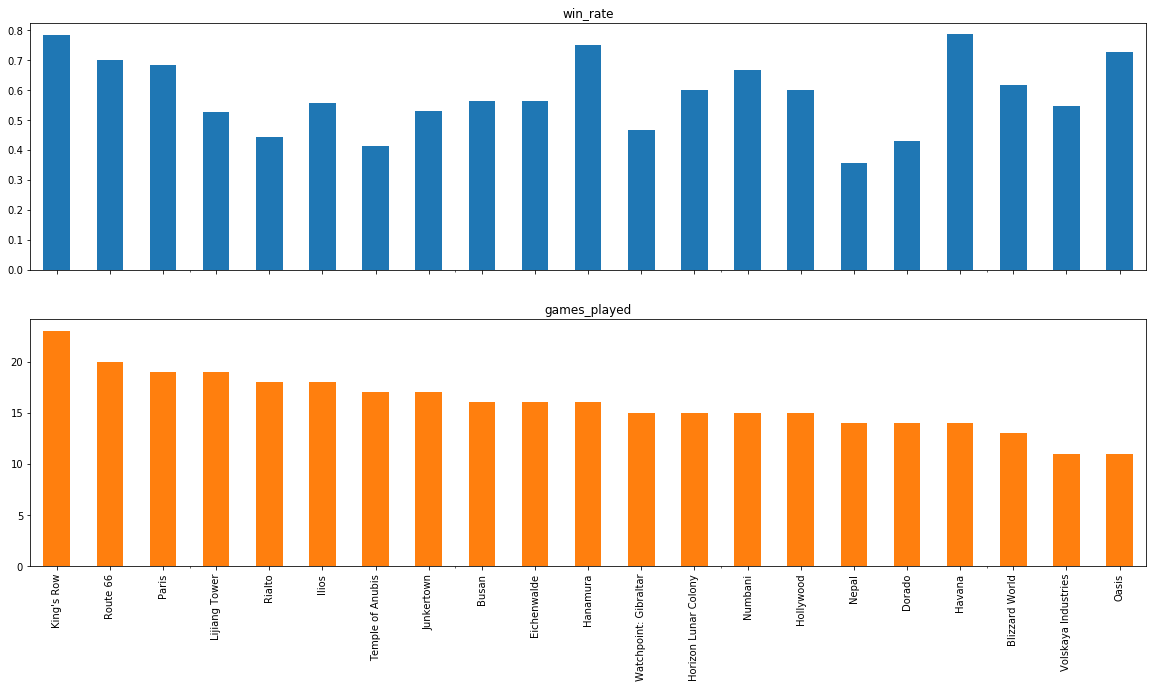

In [8]:
p=map_win_rates[['win_rate','games_played']].plot(kind="bar",figsize=(20,10),rot=90,subplots=True,legend=False)

In [11]:
points[points.role=='tank']

,hero,role,map,win_points,hero_time,result
0,zarya,tank,Oasis,1,1,WIN
1,sigma,tank,Junkertown,0,1,LOSS
10,reinhardt,tank,Oasis,0,0.52,LOSS
11,sigma,tank,Oasis,0,0.48,LOSS
12,roadhog,tank,Dorado,0,1,LOSS
...,...,...,...,...,...,...
428,zarya,tank,Volskaya Industries,1,1,WIN
431,hammond,tank,Lijiang Tower,0,1,LOSS
432,orisa,tank,Paris,0,1,LOSS
434,reinhardt,tank,King's Row,1.22,1.22,WIN
